## Importar as bibliotecas

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data fetching
import investpy

# Technical Indicators
import pandas_ta as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Importar dados

In [2]:
df = investpy.get_stock_historical_data(stock='HGTX3',
                                        country='brazil',
                                        from_date='01/01/2000',
                                        to_date='01/09/2021')

In [3]:
df = df.dropna()
df = df.iloc[:,:4]
df.tail()

,Open,High,Low,Close
Date,,,,
2021-08-26,39.15,39.94,37.89,38.03
2021-08-27,38.04,38.47,37.66,38.38
2021-08-30,38.24,38.58,37.67,38.23
2021-08-31,38.23,38.40,36.53,37.23
2021-09-01,37.32,37.38,36.28,36.98


## Definir as variáveis preditoras

Usa-se a média móvel, correlação, relative strength index (RSI), a diferença do preço de abertura de ontem e o preço de abertura de hoje, além do preço de abertura, mais alto, mais baixo e fechamento.

In [4]:
df['S_10'] = df['Close'].rolling(window=10).mean()

In [5]:
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])

In [6]:
df['RSI'] = ta.rsi(df['Close'], timeperiod =10)

In [7]:
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
df = df.dropna()
X = df.iloc[:,:9]

In [10]:
X.head()

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open
Date,,,,,,,,,
2001-07-23,0.63,0.69,0.63,0.67,0.769,0.101263,41.984184,-0.06,-0.06
2001-07-24,0.69,0.71,0.69,0.71,0.777,0.313299,43.155887,0.02,0.06
2001-07-25,0.69,0.69,0.69,0.69,0.752,0.196086,42.691619,-0.02,0.00
2001-07-26,0.63,0.63,0.63,0.63,0.731,0.166572,41.257654,-0.06,-0.06
2001-08-07,0.65,0.65,0.65,0.65,0.733,0.501271,41.957505,0.02,0.02


# Definir a variável dependente

Se o preço de fechamento de amanhã é maior que o preço de fechamento hoje, então compra-se a ação (1), ao contrário se vende (-1).

In [11]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

In [12]:
y

array([ 1, -1, -1, ..., -1, -1, -1])

# Repartir o dataset

In [13]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Instanciar a regressão logística

In [14]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

# Examinar os coeficientes

In [15]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.361898615687902]
1,High,[0.19398043087630895]
2,Low,[0.14507280109380208]
3,Close,[-0.1481769512585649]
4,S_10,[0.18293722068643378]
5,Corr,[0.13109565818005883]
6,RSI,[0.007507957115490961]
7,Open-Close,[0.11925339258590285]
8,Open-Open,[-0.07104960587803232]


# Calcular as problabilidades da classe

In [16]:
probability = model.predict_proba(X_test)
print(probability)

[[0.53038277 0.46961723]
 [0.48780346 0.51219654]
 [0.53812519 0.46187481]
 ...
 [0.4667982  0.5332018 ]
 [0.48791959 0.51208041]
 [0.44181723 0.55818277]]


# Fazer previsões

In [17]:
predicted = model.predict(X_test)

# Avaliar o modelo

- Matriz de confusão

In [18]:
print(metrics.confusion_matrix(y_test, predicted))

[[416 210]
 [351 211]]


- Relatório da classificação

In [19]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.54      0.66      0.60       626
           1       0.50      0.38      0.43       562

    accuracy                           0.53      1188
   macro avg       0.52      0.52      0.51      1188
weighted avg       0.52      0.53      0.52      1188



- Acurácia do modelo

In [20]:
print(model.score(X_test,y_test))

0.5277777777777778


- Validação-cruzada

In [21]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.53535354 0.54545455 0.53535354 0.51515152 0.45959596 0.52777778
 0.53282828 0.54545455 0.51010101 0.54040404]
0.5247474747474749


# Estratégia de trading

Prevemos o sinal para comprar (1) ou vender (-1) e calculamos os retornos acumulativos para os dados de treino. Em seguida, o retorno estratégico acumulativo baseado no sinal previsto pelo modelo nos dados de teste.

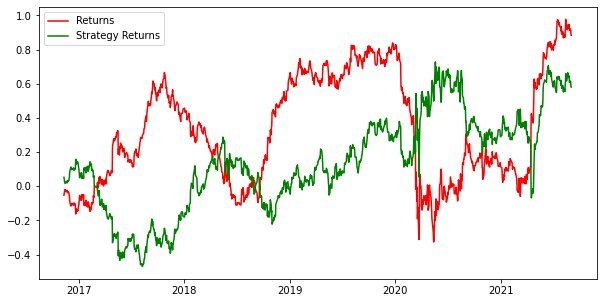

In [22]:
df['Predicted_Signal'] = model.predict(X)
df['Returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(df[split:]['Returns'])

df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()